In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tools_ryu import mytool

In [2]:
d = pd.read_pickle("coinmarketcap_data/coinmarketcap_data.pickle")
vol = pd.pivot_table(data=d,
                     values="vol", 
                     index="date", 
                     columns="coin_id")

vol_mask = (vol.rolling(window=30).mean() > 10_000_000).replace({True:1,
                                                                 False: np.nan})

In [3]:
mktcap = pd.read_pickle("mktcap_pp2.pickle")
price = pd.read_pickle("close_pp2.pickle") \
          .replace(0, np.nan)

daily_rtn = price.pct_change(fill_method=None)
mktcap_mask = (mktcap.rolling(window=30).mean() > 1_000_000) \
                     .replace({True:1,
                               False:np.nan})

mktcap_screened = (mktcap * mktcap_mask * vol_mask)

In [4]:
# 시작일 찾기
start_idx = (mktcap_screened.isna().sum(1) < 10616).replace(False,np.nan).dropna().index[0]

# weight 계산
weight = mktcap_screened.loc[start_idx:].apply(lambda x: x / np.nansum(x), axis=1)

# 마켓 인덱스 만들기
mkt_index = (daily_rtn*weight.shift(1)).sum(1)

In [5]:
start_idx

Timestamp('2014-01-05 00:00:00')

Cross-Sectional-Momentum : Weekly Rebalancing

In [6]:
weekly_mktcap = mktcap_screened.loc[start_idx:].resample("W").last()
weekly_rtn = price.loc[start_idx:].pct_change(7,fill_method=None) \
                  .resample("W").last()
weekly_price = price.loc[start_idx:].resample("W").last()
weekly_vol_mask = vol_mask.loc[start_idx:].resample("W").last()

In [7]:
# Momentum 그룹을 구하기 위해서 필요함
weekly_rtn_pp = weekly_rtn * np.sign(weekly_mktcap) * weekly_vol_mask

In [8]:
# 언제부터 시작하는 지 찾자 (최소 100개의 코인이 필요)
cnt = weekly_rtn_pp.count(1)
more100 = cnt.loc[cnt > 99] # 여기서 start date가 나온다
start = more100.index[0]
more100

date
2018-01-07    101
2018-01-14    108
2018-01-21    118
2018-01-28    123
2018-02-04    120
             ... 
2023-03-19    300
2023-03-26    282
2023-04-02    252
2023-04-09    264
2023-04-16    259
Length: 157, dtype: int64

In [9]:
weekly_rtn_sample_pp = weekly_rtn_pp.loc[start:]
weekly_mktcap_sample = weekly_mktcap.loc[start:]
weekly_price_sample = weekly_price.loc[start:]

In [10]:
# rank를 계산해줍니다
rank = weekly_rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//5)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])
t4 = rank_thresh.apply(lambda x: x[4])

rank_thresh

date
2018-01-07       [0, 20, 40, 60, 80, 100]
2018-01-14       [0, 21, 42, 63, 84, 105]
2018-01-21       [0, 23, 46, 69, 92, 115]
2018-01-28       [0, 24, 48, 72, 96, 120]
2018-02-04            [0, 24, 48, 72, 96]
                         ...             
2023-03-19         [0, 60, 120, 180, 240]
2023-03-26    [0, 56, 112, 168, 224, 280]
2023-04-02    [0, 50, 100, 150, 200, 250]
2023-04-09    [0, 52, 104, 156, 208, 260]
2023-04-16    [0, 51, 102, 153, 204, 255]
Freq: W-SUN, Length: 276, dtype: object

In [11]:
g1_mask = rank.apply(lambda x: x <= t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 < x)&(x <= t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 < x)&(x <= t3), axis=0) \
              .replace({True:1, False:np.nan})
g4_mask = rank.apply(lambda x: (t3 < x)&(x <= t4), axis=0) \
              .replace({True:1, False:np.nan})
g5_mask = rank.apply(lambda x: x > t4, axis=0) \
              .replace({True:1, False:np.nan})           

In [12]:
# 각 그룹별 weight를 생성
weight_g1 = (g1_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g5 = (g5_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

In [13]:
# 그룹별 코인 개수 출력 
concat = pd.concat([weight_g1.count(1), weight_g2.count(1),
                    weight_g3.count(1), weight_g4.count(1),
                    weight_g5.count(1)], axis=1)#.plot();

coin = pd.concat([concat, concat.sum(1)], axis=1)
coin.columns = [0,1,2,3,4,"Sum"]

coin

,0,1,2,3,4,Sum
date,,,,,,
2018-01-07,20,20,20,20,21,101
2018-01-14,21,21,21,21,24,108
2018-01-21,23,23,23,23,26,118
2018-01-28,24,24,24,24,27,123
2018-02-04,24,24,24,24,24,120
...,...,...,...,...,...,...
2023-03-19,60,60,60,60,60,300
2023-03-26,56,56,56,56,58,282
2023-04-02,50,50,50,50,52,252


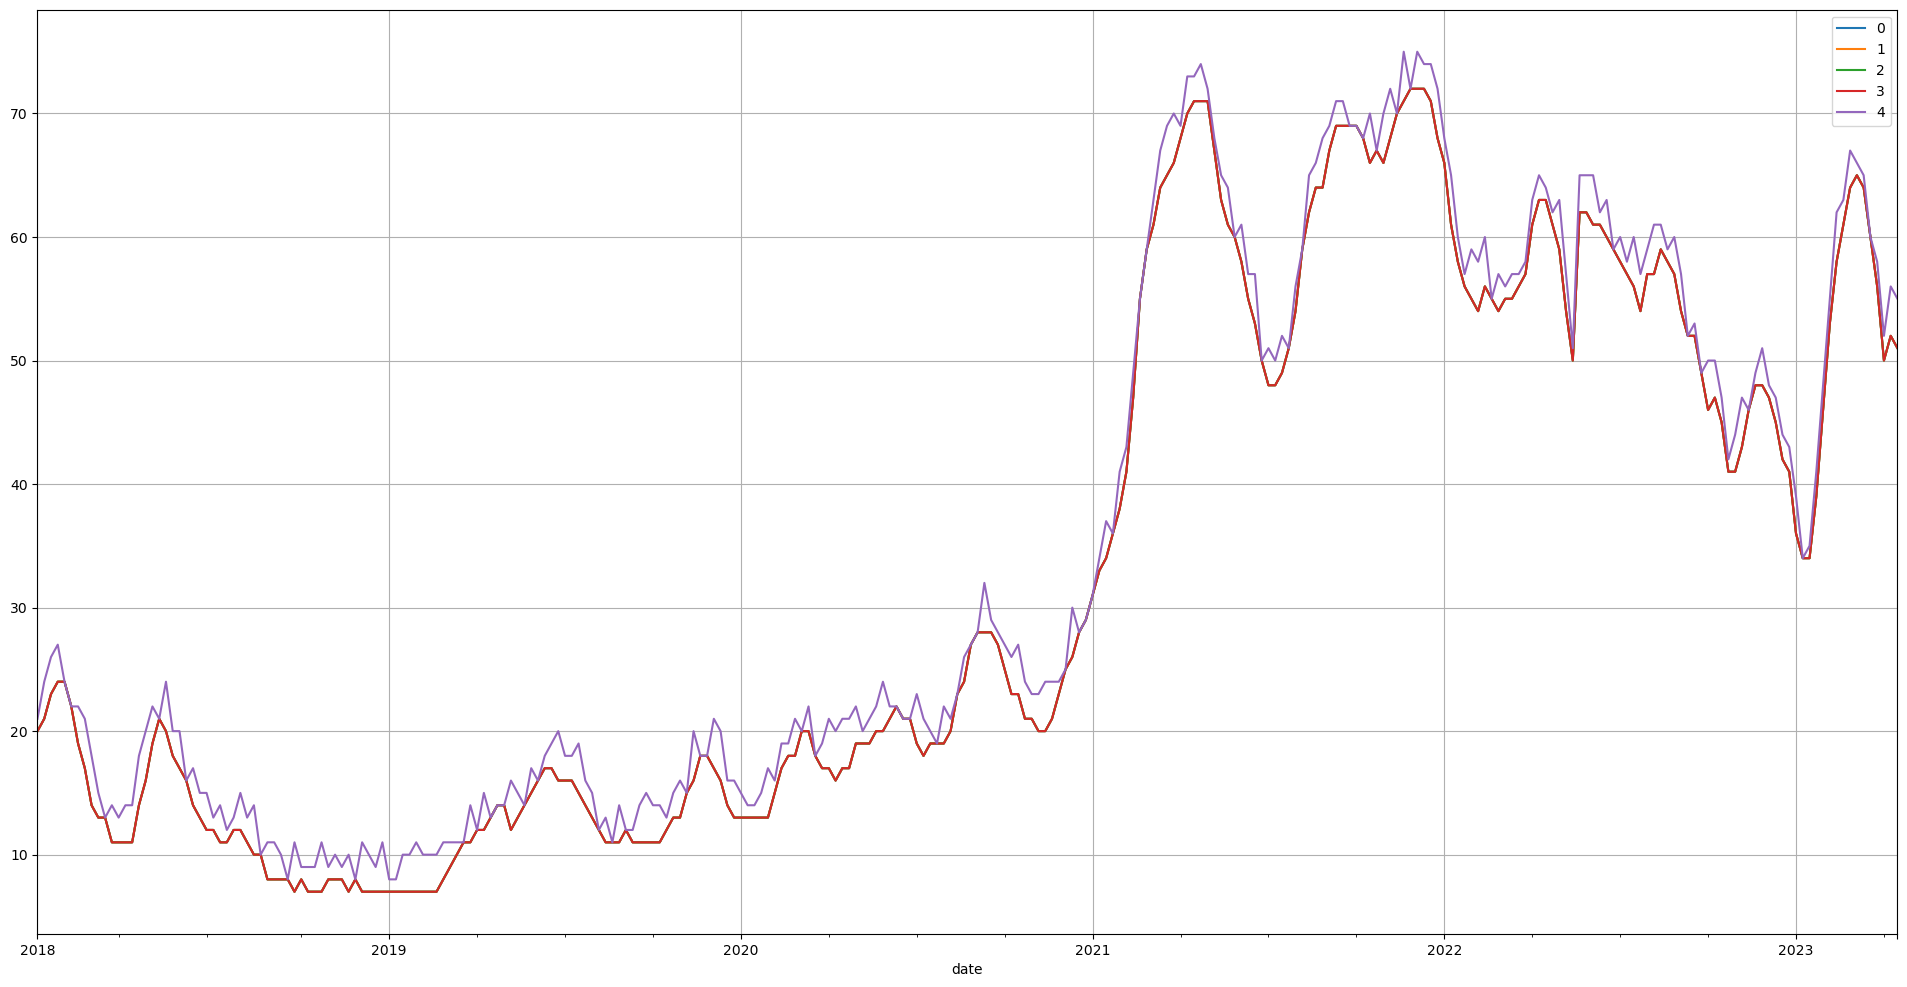

In [14]:
concat.plot(figsize=(24,12))
plt.grid();

In [15]:
# filter를 마켓켑과 리턴에 곱해줘서 각 그룹별 리턴 계산
rtn_g1 = (weekly_rtn.loc[start:] * weight_g1.shift(1))#.sum(1)
rtn_g2 = (weekly_rtn.loc[start:] * weight_g2.shift(1))#.sum(1)
rtn_g3 = (weekly_rtn.loc[start:] * weight_g3.shift(1))#.sum(1)
rtn_g4 = (weekly_rtn.loc[start:] * weight_g4.shift(1))#.sum(1)
rtn_g5 = (weekly_rtn.loc[start:] * weight_g5.shift(1))#.sum(1)

In [16]:
pf1 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g1, price, start)
pf2 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g2, price, start)
pf3 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g3, price, start)
pf4 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g4, price, start)
pf5 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g5, price, start)

rtn_dict = {"Q1":pf1,
            "Q2":pf2,
            "Q3":pf3,
            "Q4":pf4,
            "Q5":pf5}

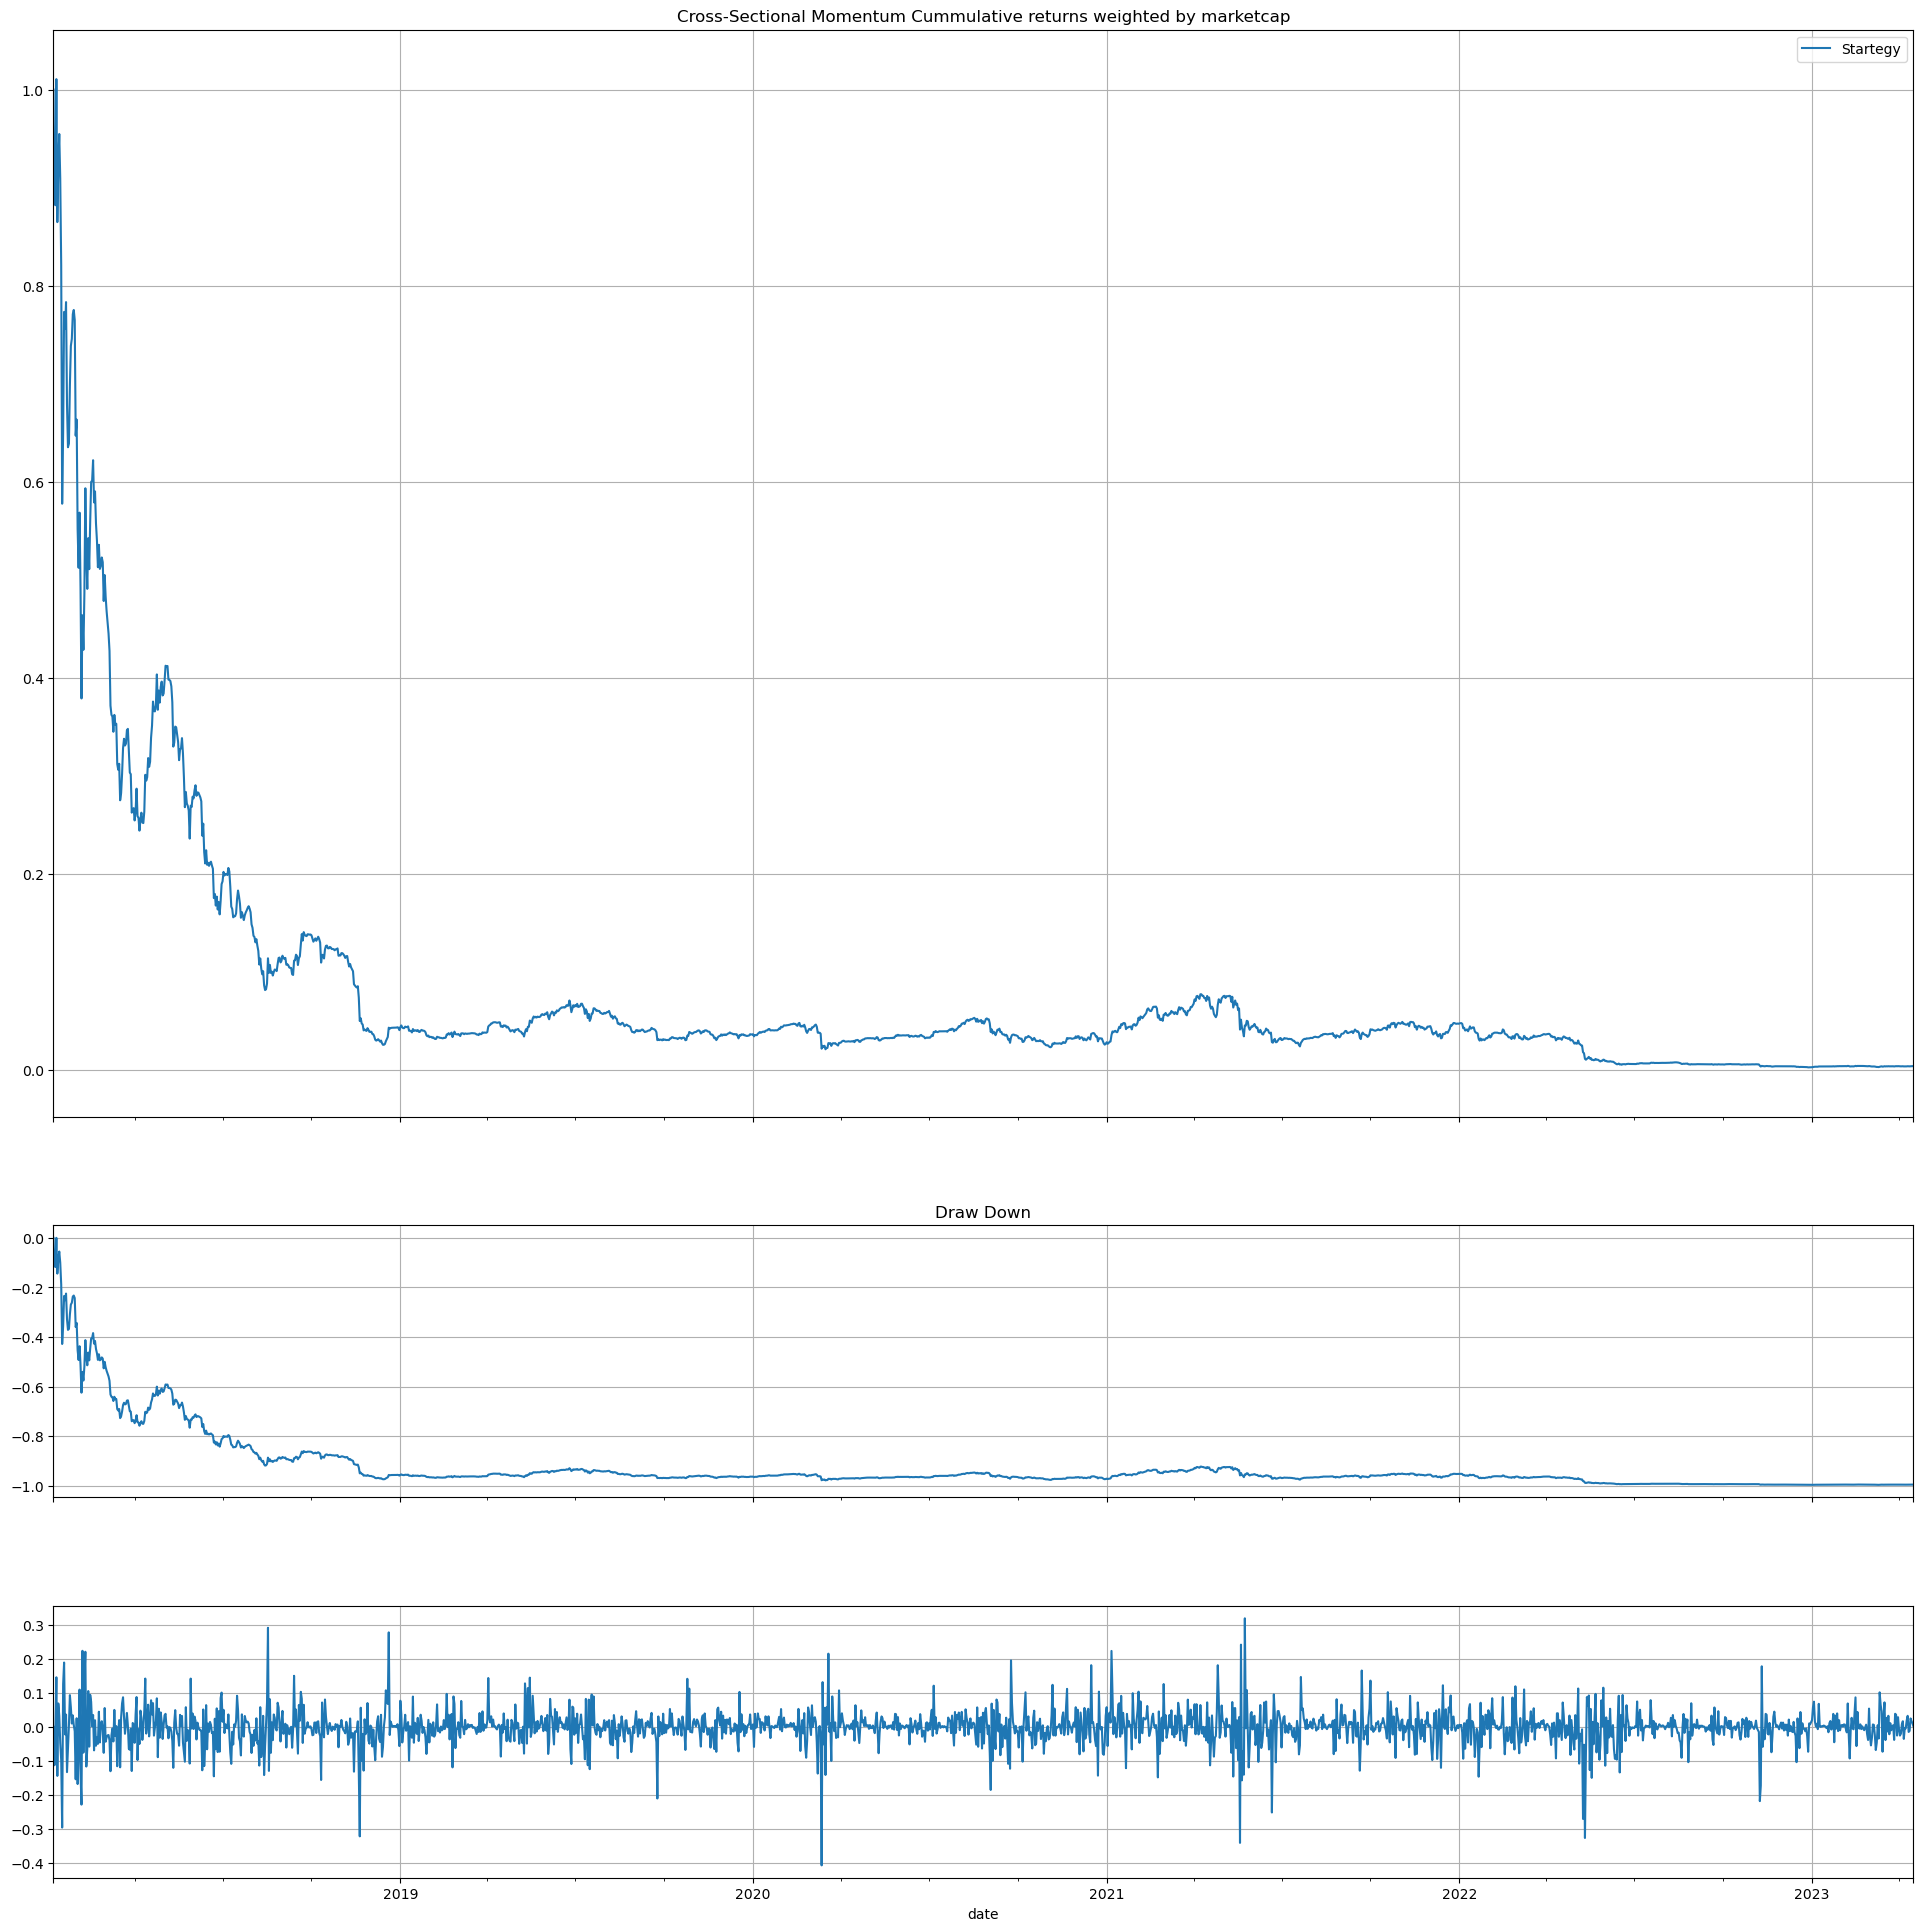

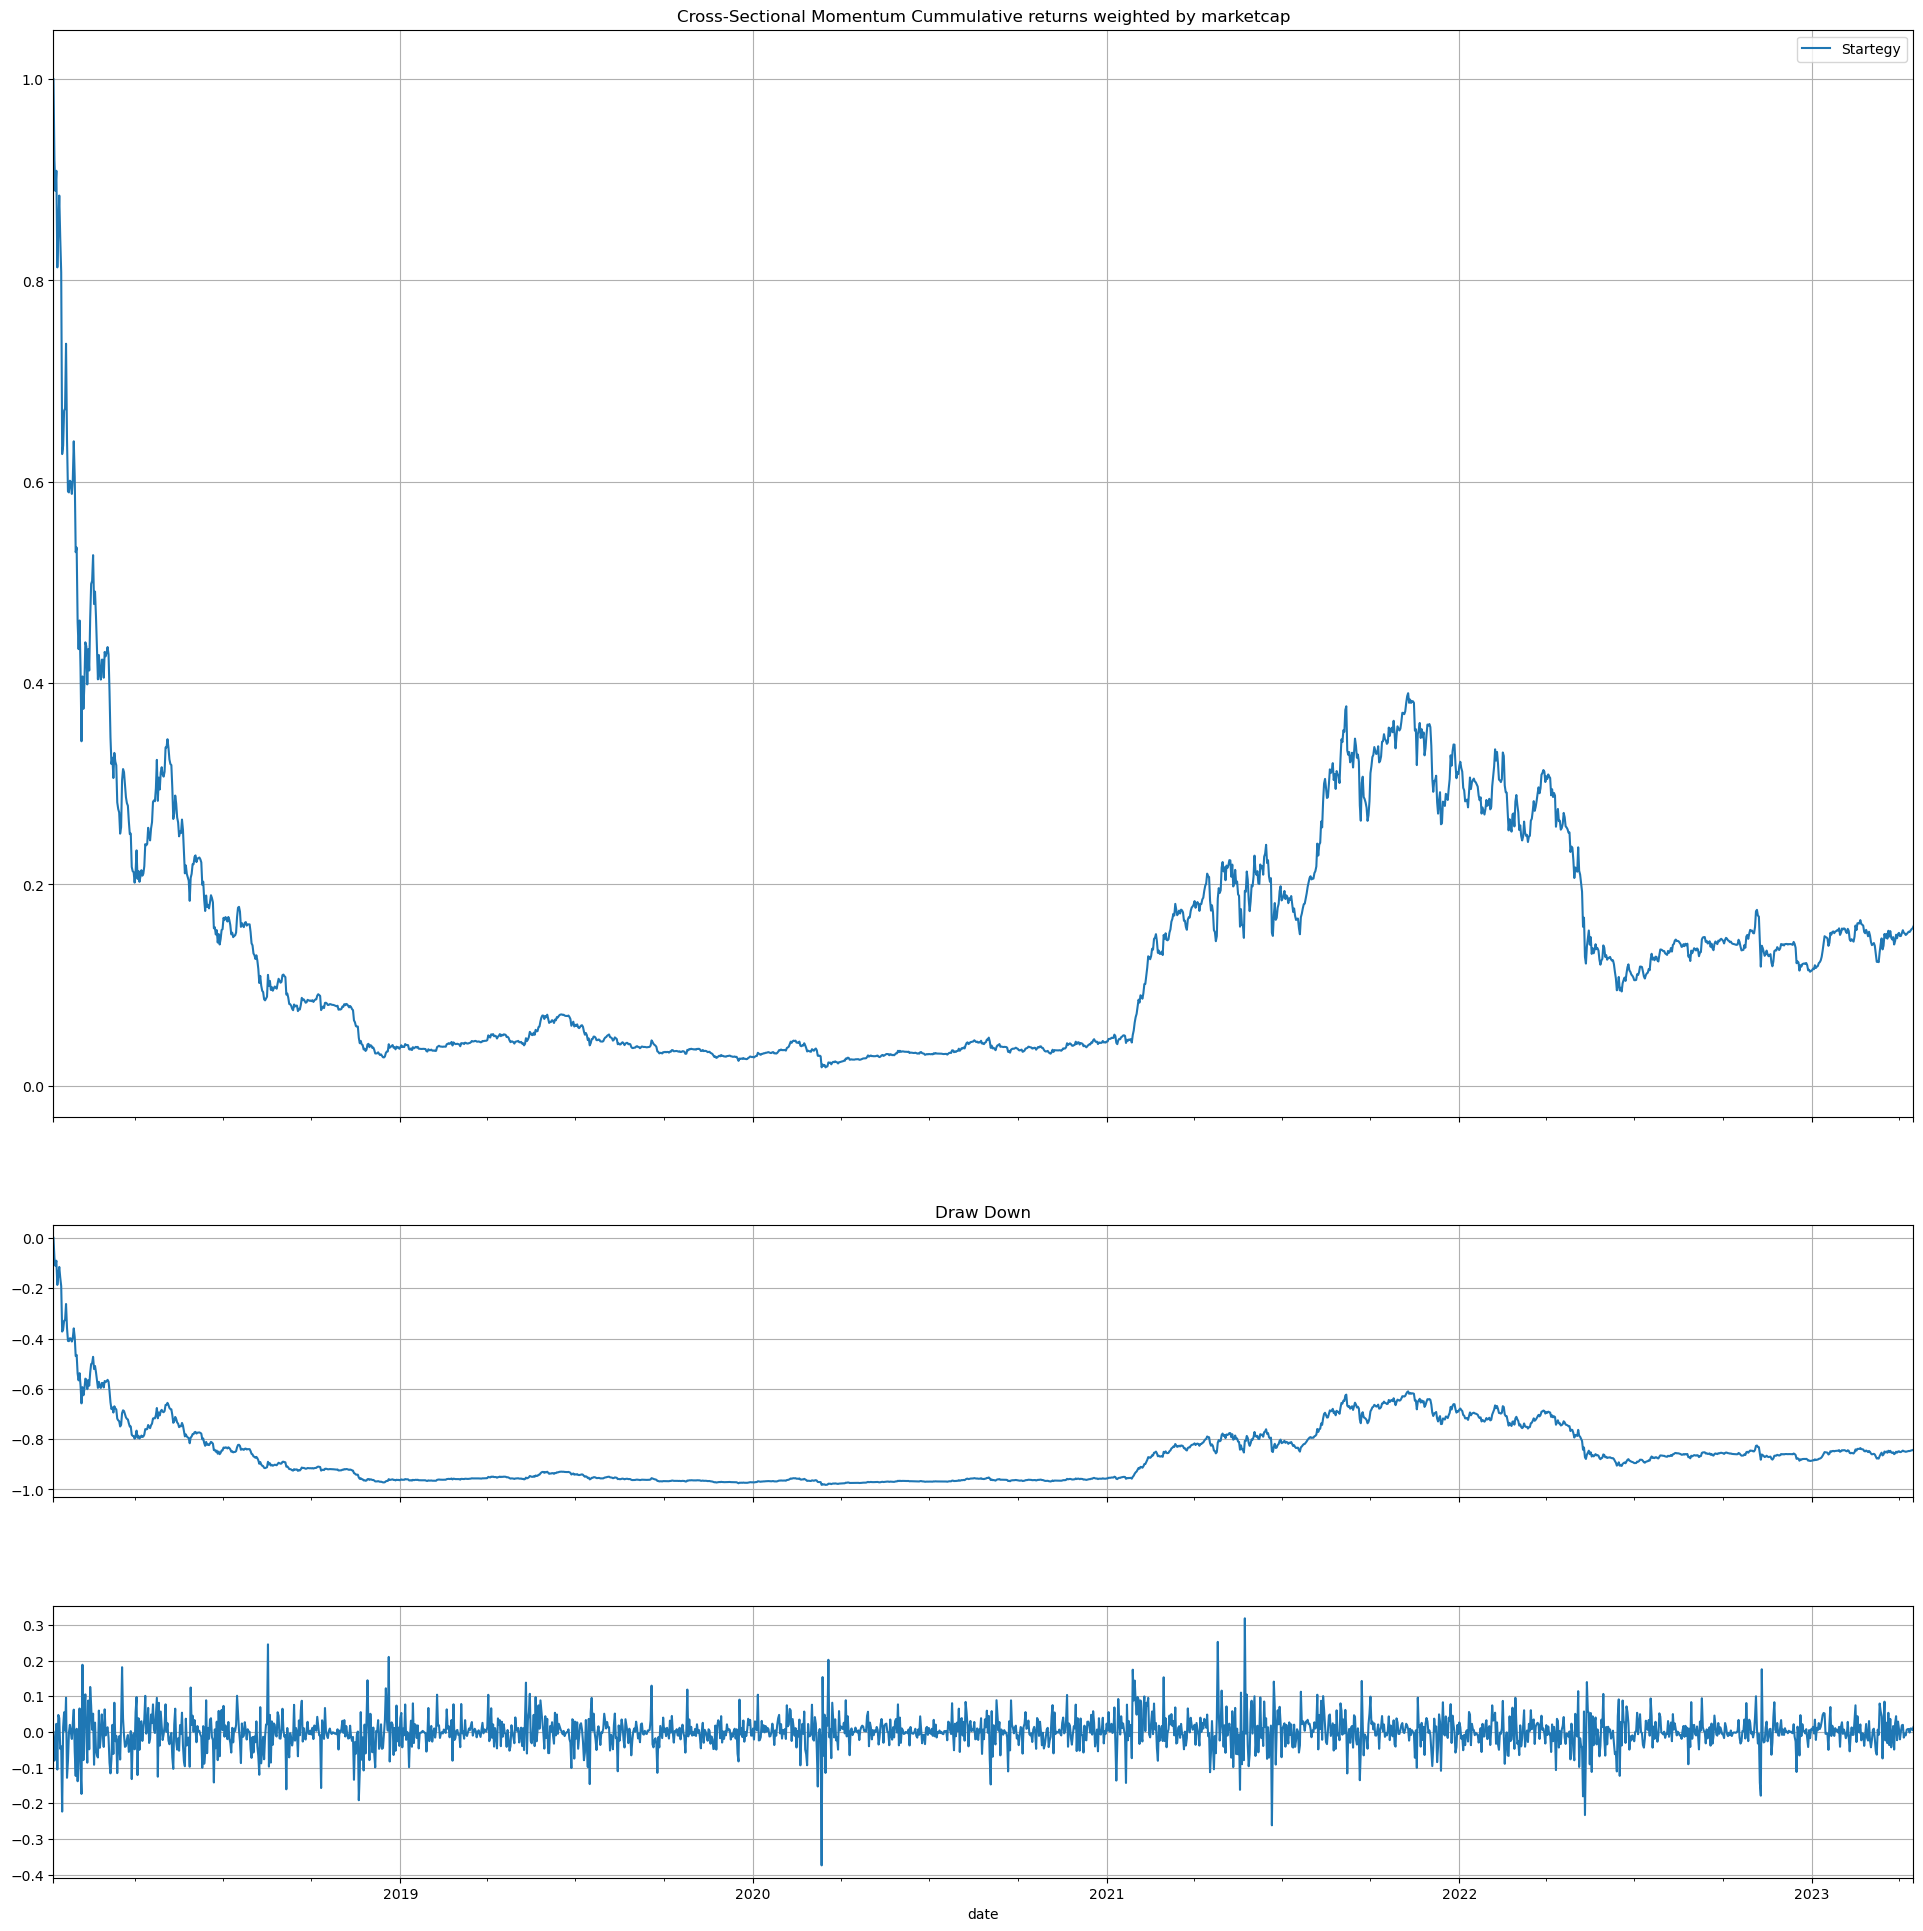

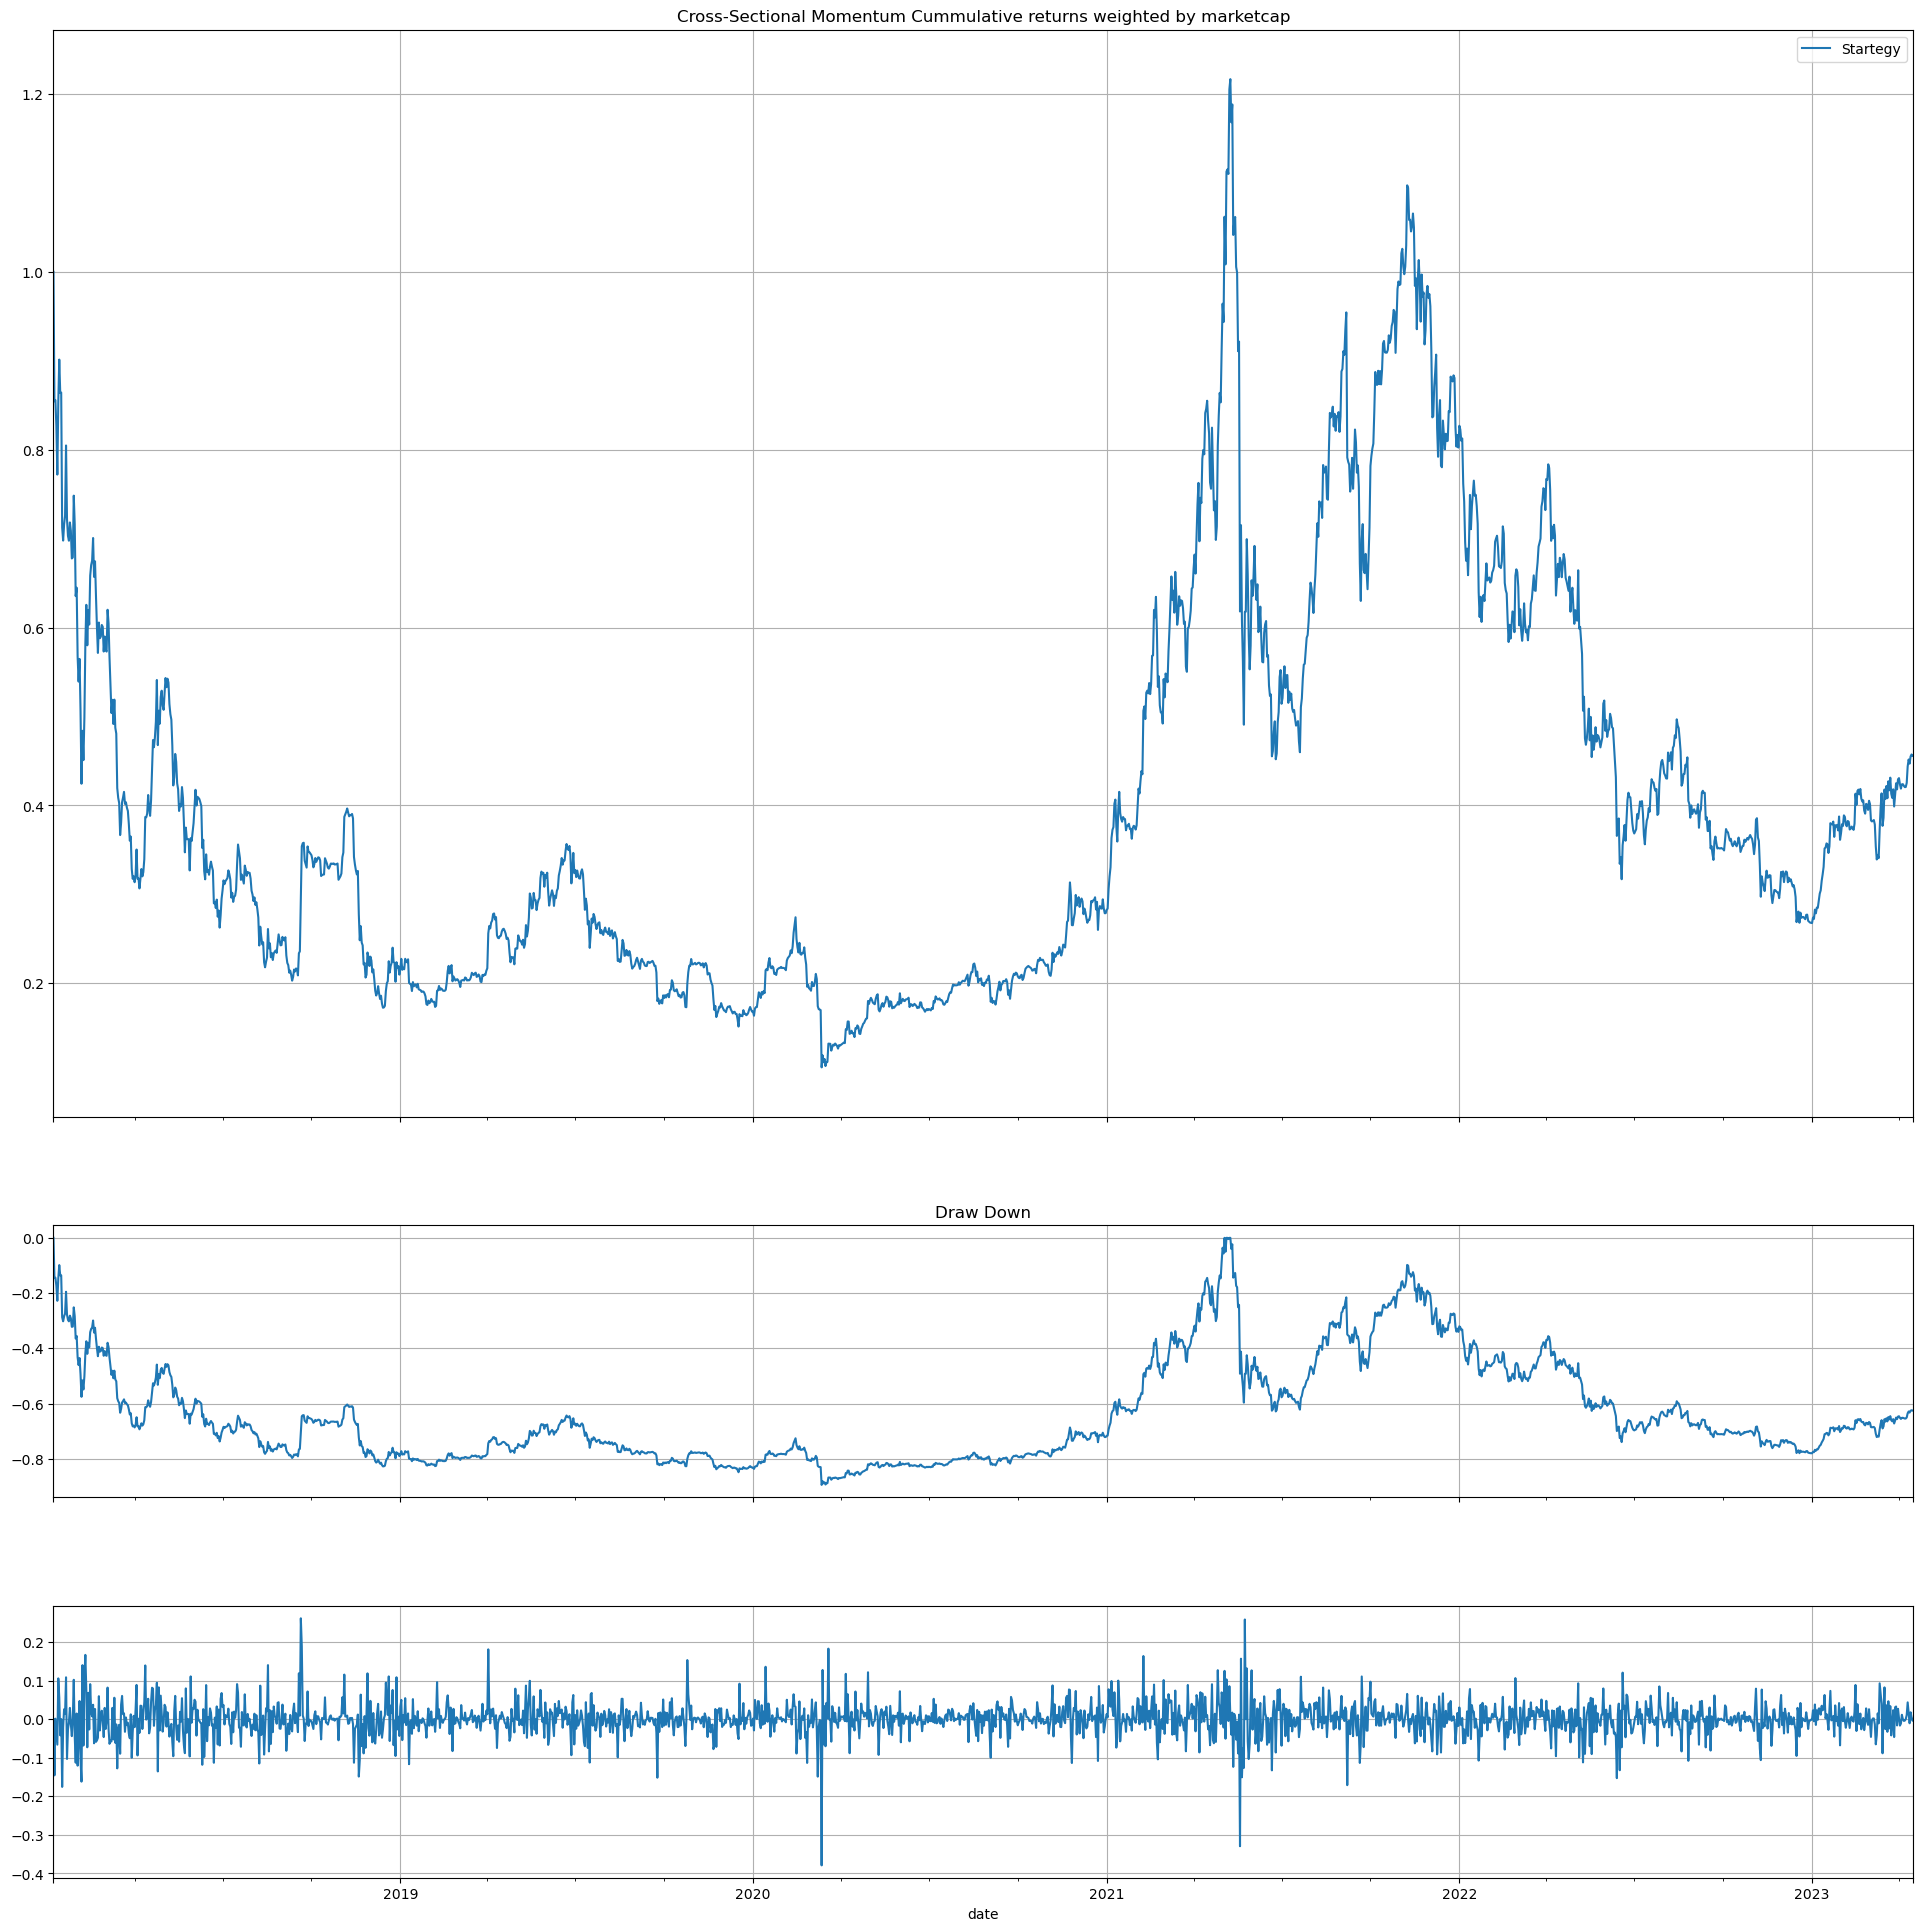

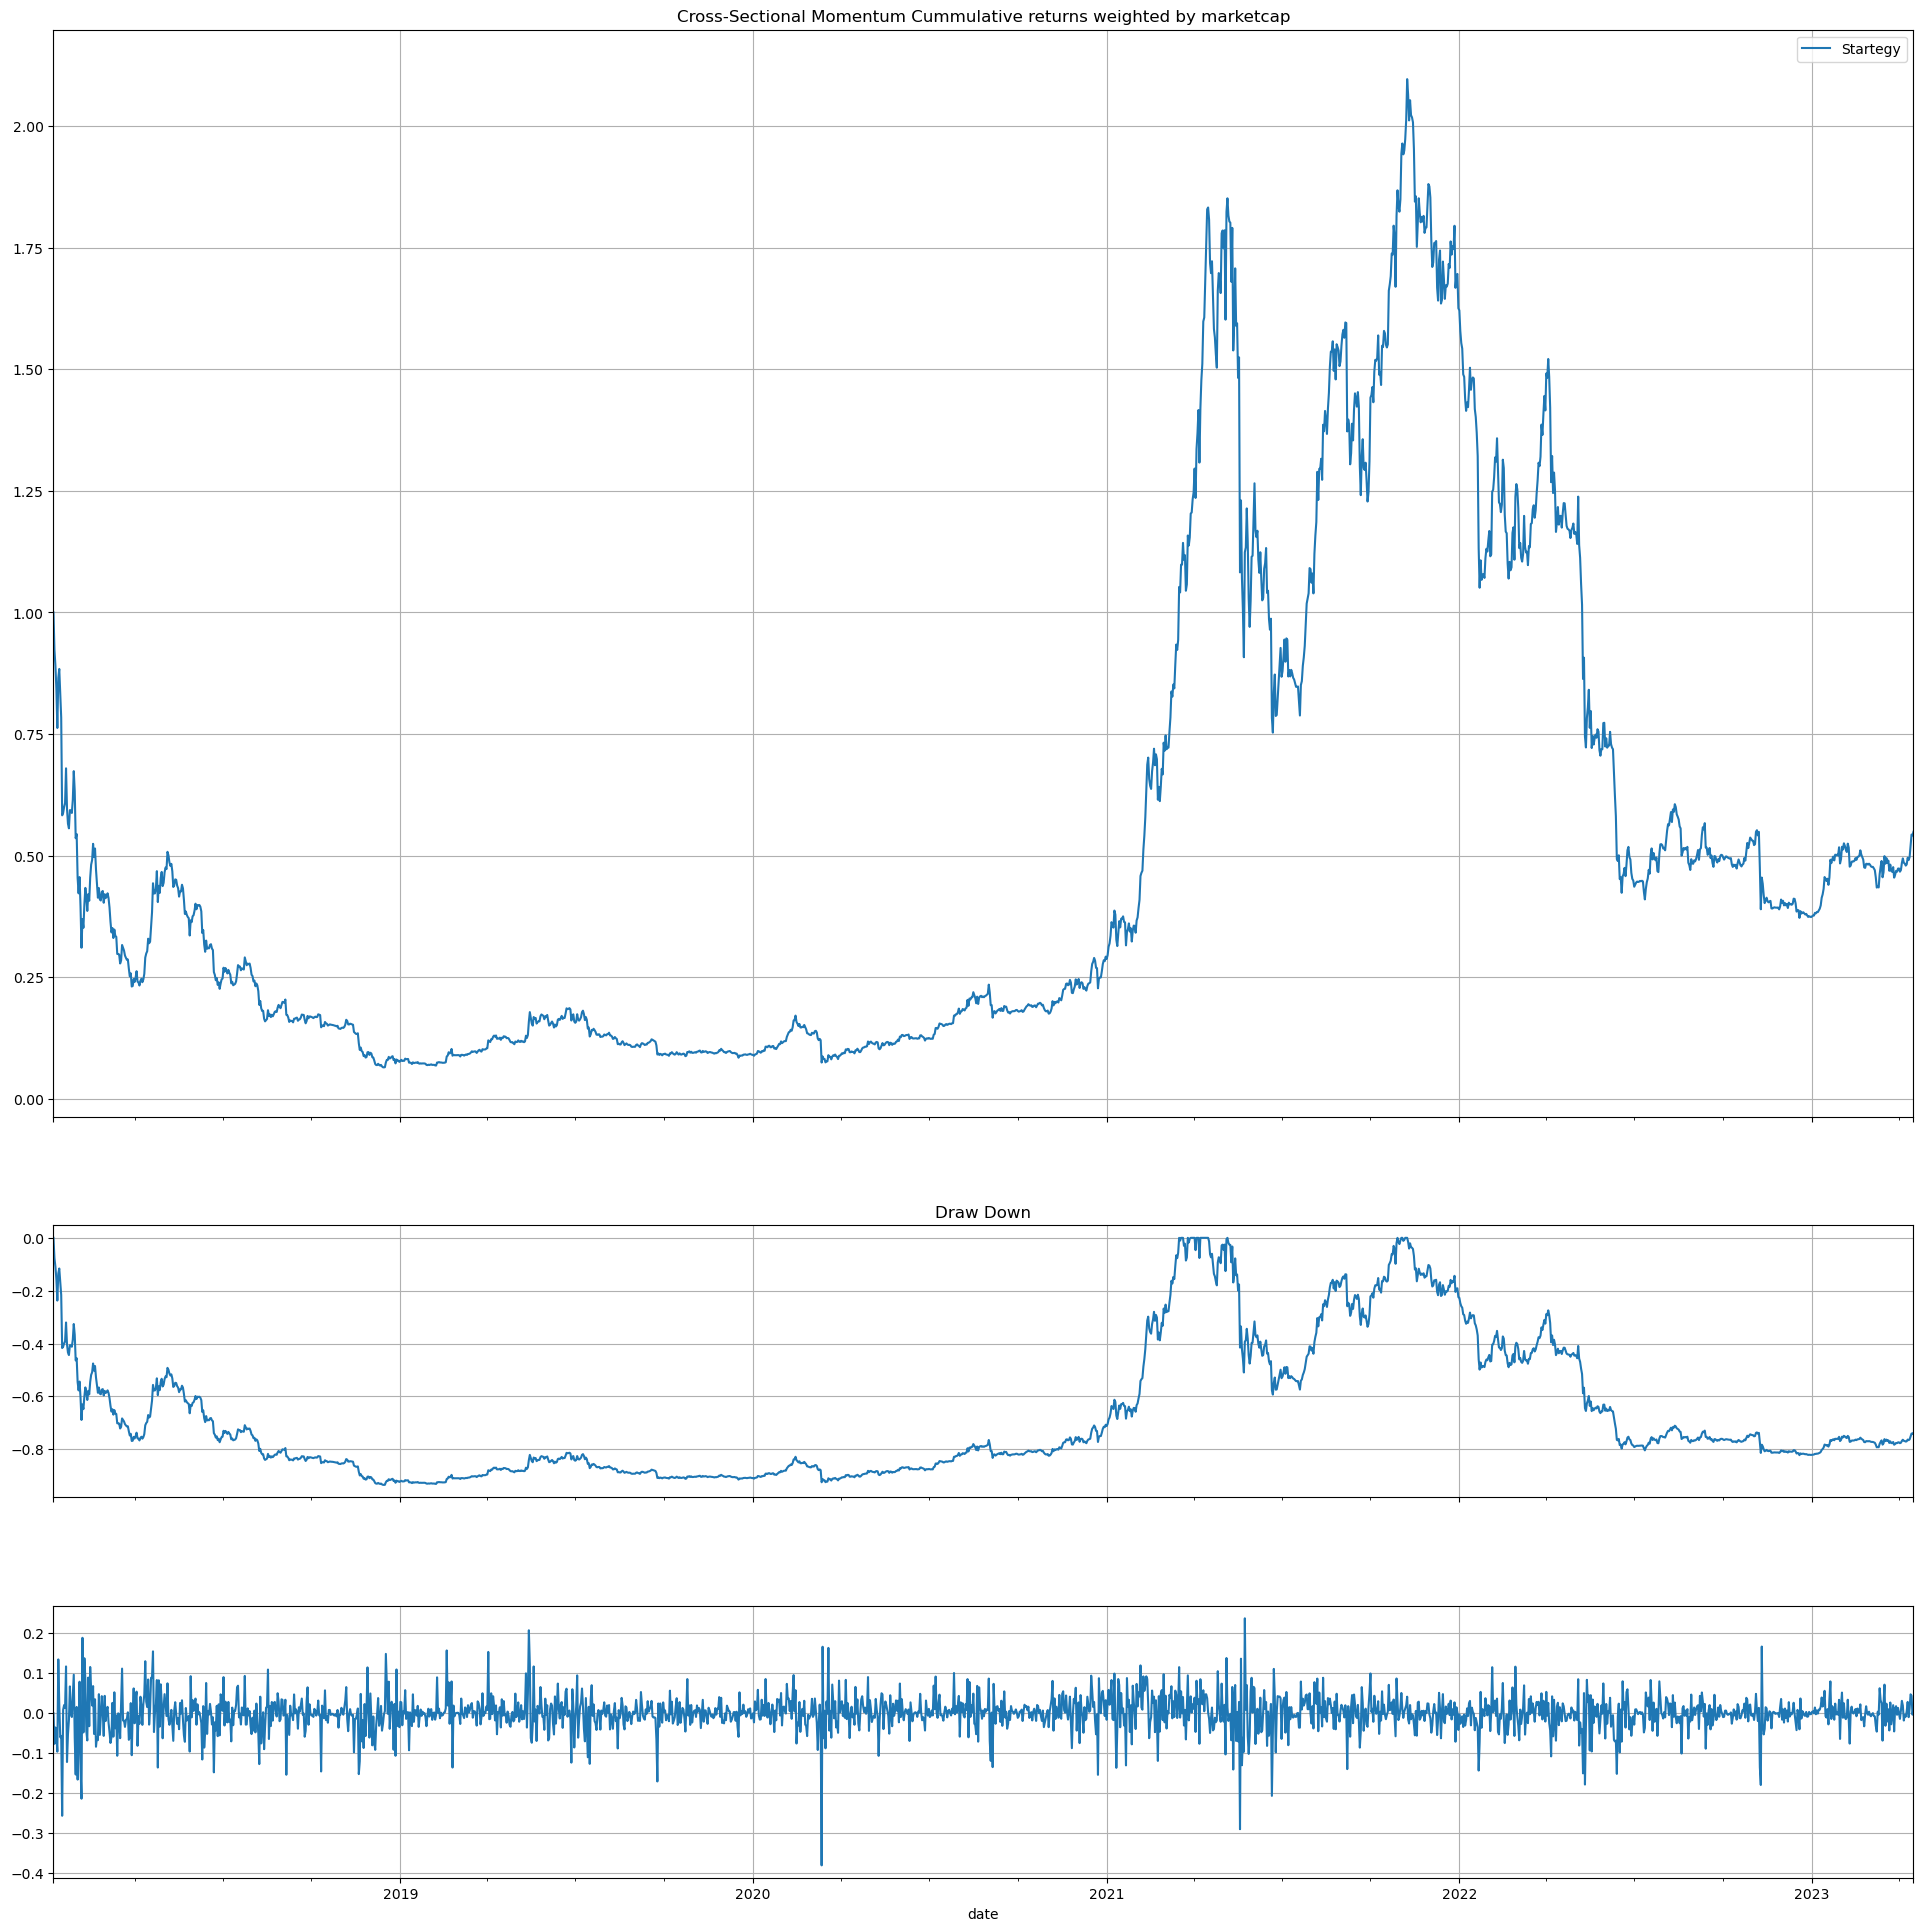

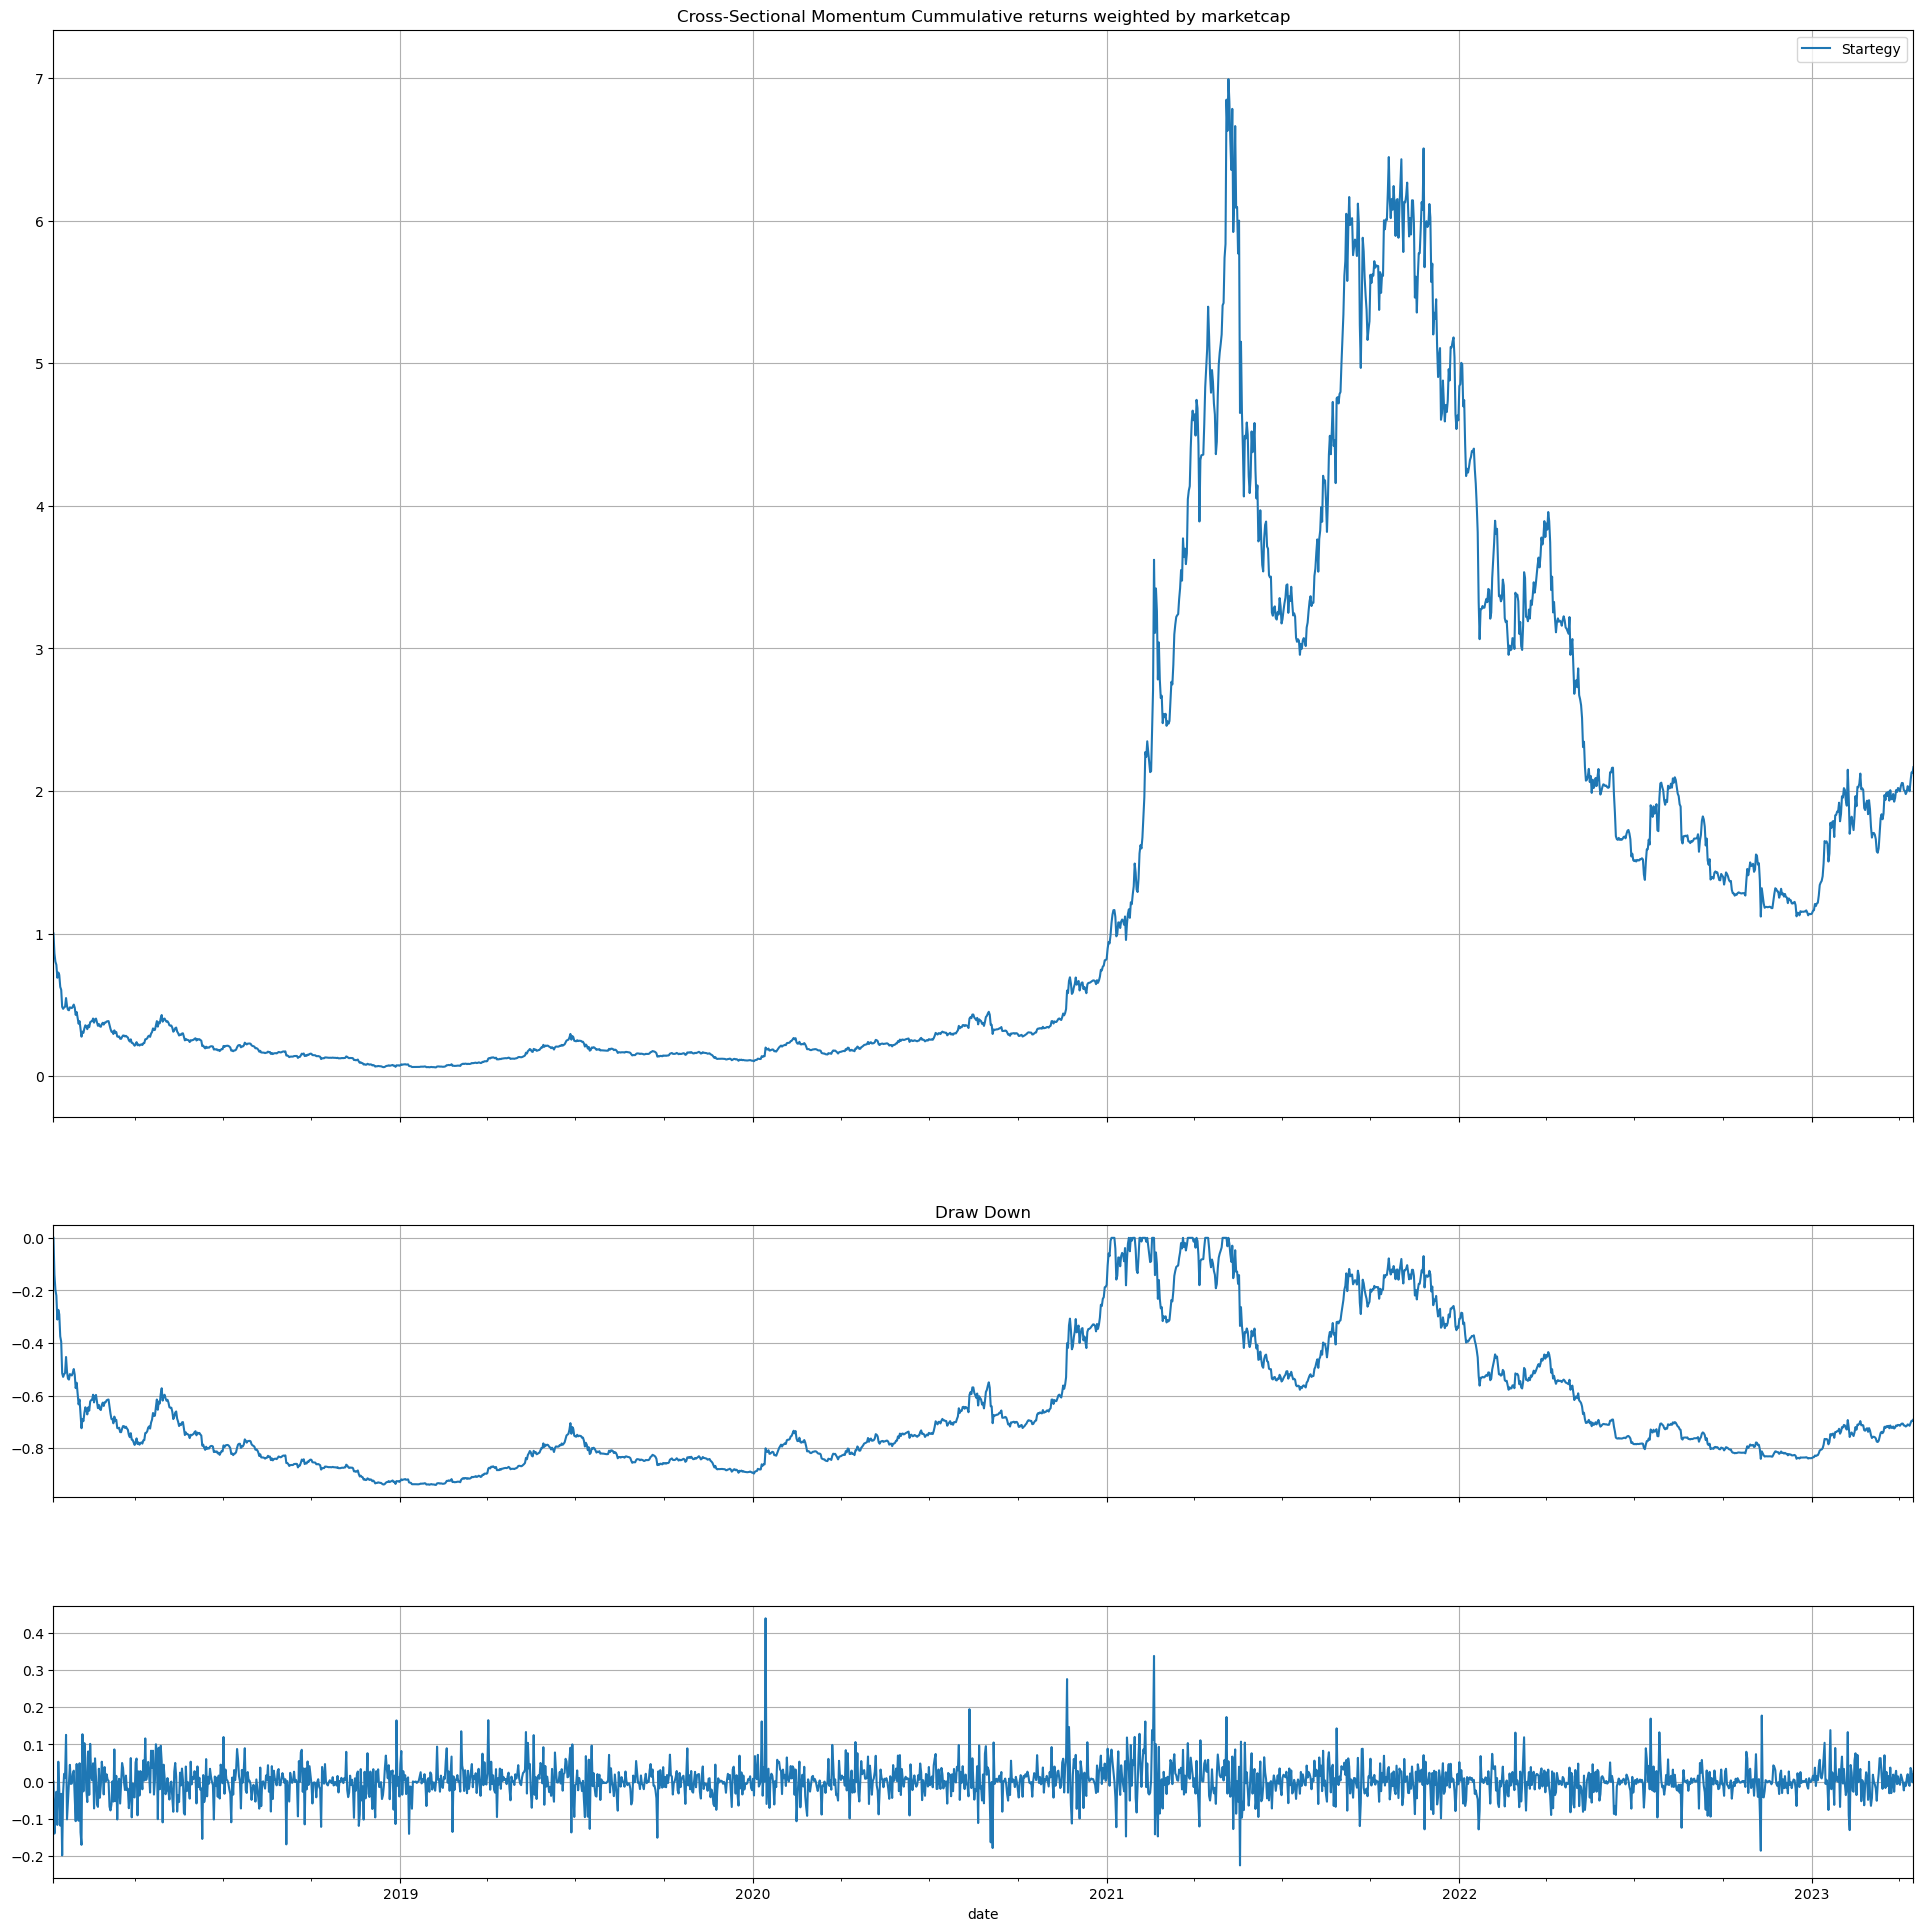

In [17]:
mytool.draw_return_result(rtn_dict, with_mkt= False)# mkt_rtn= mkt_index.loc[start:])

In [18]:
mytool.print_statistics(rtn_dict, mkt_rtn=mkt_index[start:])

,0,1,2,3,4,MKT
CAGR,-63.571268,-28.359919,-11.222173,-9.390053,19.144220,0.505154
Mean,-0.508348,0.060148,0.203993,0.262870,0.542997,0.262823
STD,1.004731,0.897791,0.831527,0.855162,0.894415,0.738886
Sharpe,-0.505954,0.066996,0.245323,0.307392,0.607098,0.355702


In [19]:
mytool.run_alpha_regression(rtn_dict, mkt_index[start:])

Q1 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.676     
Dependent Variable: y                AIC:                -8041.2585
Date:               2023-04-21 15:04 BIC:                -8030.1331
No. Observations:   1925             Log-Likelihood:     4022.6    
Df Model:           1                F-statistic:        4008.     
Df Residuals:       1923             Prob (F-statistic): 0.00      
R-squared:          0.676            Scale:              0.00089724
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const       -0.0022     0.0007   -3.2184   0.0013   -0.0035   -0.0009
0            1.1178     0.0177   63.3064   0.0000    1.0832    1.1524
-------------------------------------------------------------------
Omnibus:             263.810       

In [20]:
longshort = (rtn_dict["Q5"] - rtn_dict["Q1"])

mytool.print_statistics({"long_short": longshort})

,0
CAGR,105.578529
Mean,1.051345
STD,0.825372
Sharpe,1.273783


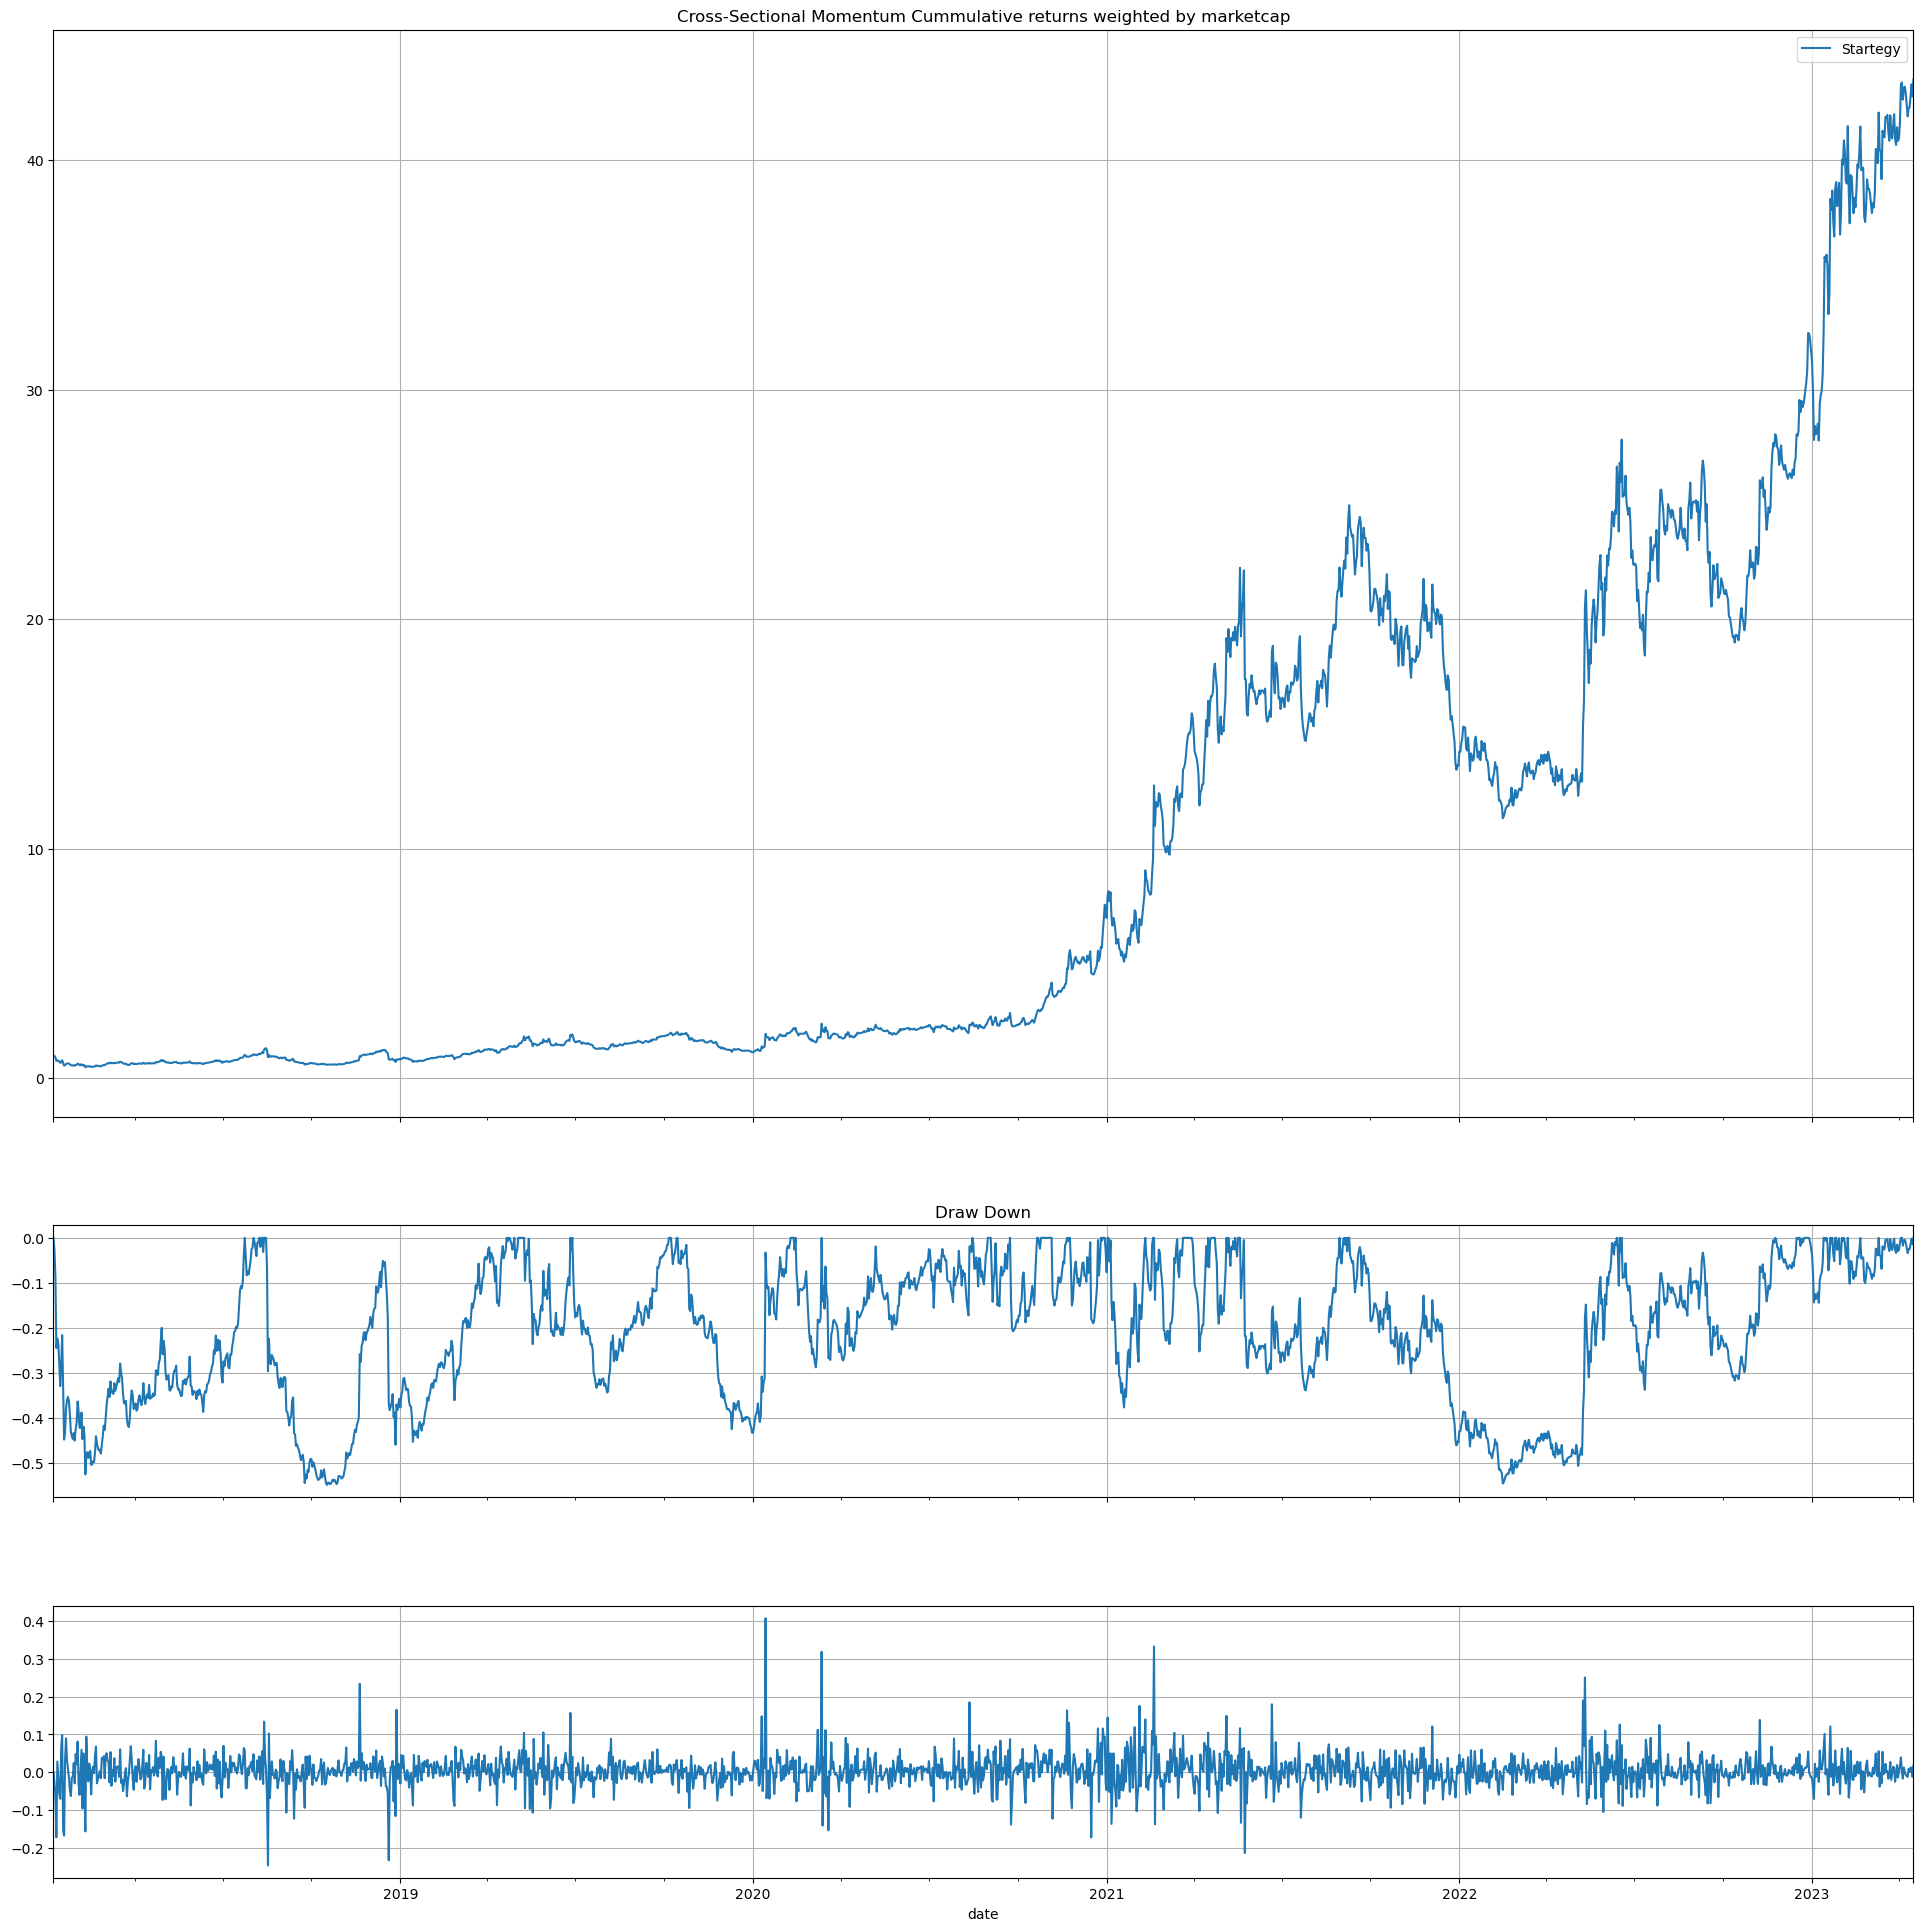

In [21]:
mytool.draw_return_result({"Q5Q1":longshort})